# Credit Card Fraud Challenge

### Karim Amjar, Cédric Bailly, Thomas Jalabert, Thomas Mahiout, Vincent Raybaud, Tiffanie Schreyeck

Source : https://www.kaggle.com/currie32/predicting-fraud-with-tensorflow

#### Exploring the Data

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

In [11]:
df = pd.read_csv("creditcard.csv") # On charge le fichier en mémoire
df.head() # affiche les 5 premières lignes

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Chaque instance représente une transaction qui est consituée de 31 attributs. 
- Il y a un attribut $Time$ qui représente le temps, en seconde, écoulé depuis la première transaction. Environ deux jours séparent la première transaction de la dernière.
- Un attribut $Amount$ qui représente le montant de la transaction.
- Un attribut $Class$ qui permet de savoir si la transaction est frauduleuse ou non. Il vaut `1` dans le cas d'une fraude, `0` sinon.
- 28 autres attributs classés de $V1$ à $V28$.

Les attributs $Vx$ ne sont pas explicitement définis par la base de données mais sont des éléments constitutifs de la transaction. L'information est sûrement cachée à des fin de protection des données bancaires. De plus, un traitement supplémentaire a peut-être été effectué sur ces données pour que l'on ne connaisse pas leur vraie fonction.

In [26]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Il n'y a aucune donnée manquante dans ce dataset. Nous allons commencé par chercher si il existe d'éventuelles corrélations entre les différents attributs.

#### Matrice de corrélation

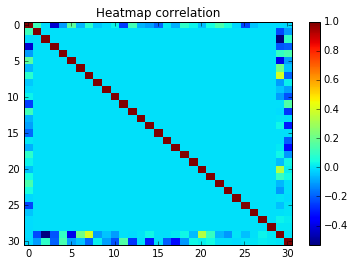

In [27]:
df_corr = df.corr()
plt.title('Heatmap correlation')
plt.imshow(df_corr, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

On remarque certaines corrélations entre l'heure de la transaction et la pluspart des autres attributs et de même pour le montant de la transaction (les éléments aux extrémités de la carte). 
Cependant la très grande majorité des autres attributs ne sont pas corrélés entre eux.

##### Identifier les fraudes grâce au temps

In [13]:
print ("Fraud:\n")
print (df.Time[df.Class == 1].describe())
print ()
print ("Normal:")
print (df.Time[df.Class == 0].describe())

Fraud:

count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

Normal:
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


Ici, on cherche à comparer les deux classes de données. Il y a peut-être une différence sur la répartition dans le temps entre une fraude et une transaction normale.
Il n'y a pas de moyen de distinguer les deux classes par ce biais.
On remarque qu'il y a seulement 492 fraudes pour 284315 + 492 transactions dans cet ensemble de données (0.172%).

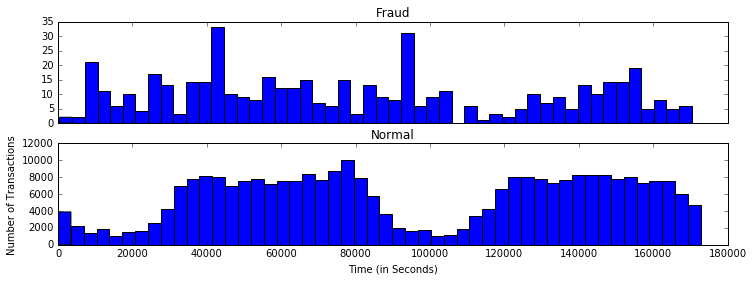

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(df.Time[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Time[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

Ici, on cherche à identifier si les transactions en fraudes se passent à des moments particuliers de la journée. Ici on voit bien que les transactions normales diminuent progressivement durant la nuit. Mais les fraudes ne sont pas atteintes par cette baisse.

> You could argue that fraudulent transactions are more uniformly distributed, while normal transactions have a cyclical distribution.

Ici l'auteur estime que les transactions frauduleuses suivent une loi uniformément distribuée alors que les transactions normales suivent une distribution cyclique.

##### Distinguer les classes grâce au montant

In [16]:
print ("Fraud")
print (df.Amount[df.Class == 1].describe())
print ()
print ("Normal")
print (df.Amount[df.Class == 0].describe())

Fraud
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Normal
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


Ici on essaie de savoir s'il y a une différence significative entre les montants des deux types de transactions. Cet attribut ne permet cependant pas de déterminer la classe d'une transaction.

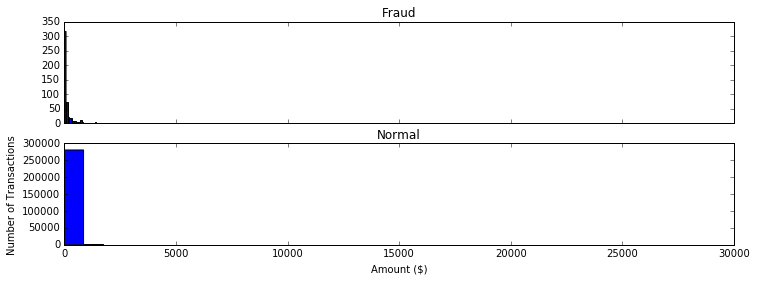

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(df.Amount[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
#plt.yscale('log')
plt.show()


Même si le nombre de transactions normales est beaucoup plus élevé que les fraudes, la répartition globale du montant est la même, c'est-à-dire que la grande majorité des transactions ont des petits montants.

On va maintenant essayer d'analyser les élements anonymes $V_x$. En effet, bien que ces données aient été cryptés par l'entreprise, si on observe une distribution différente entre les deux types de transactions (normales vs. frauduleuses) cela nous indiquera quels élements sont pertinents à analyzer (pour l'entreprise) afin de détecter une fraude.

In [18]:
# Extraction des élements anonymes seulement
v_features = df.ix[:,1:29].columns

C:\Users\Cédric\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



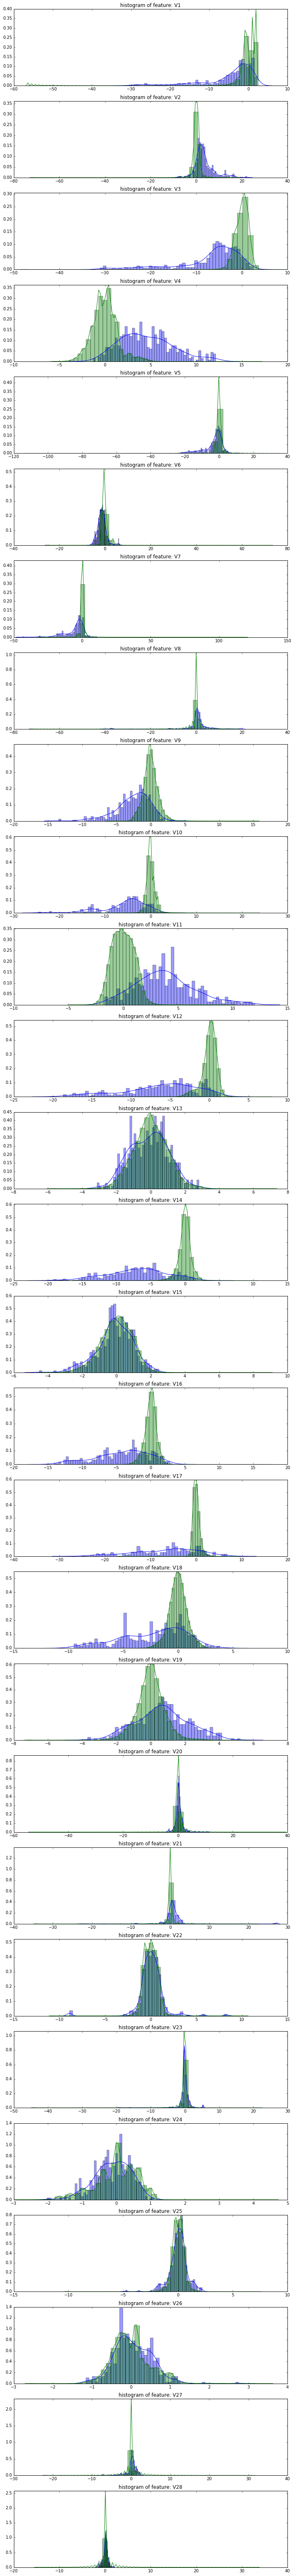

In [24]:
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[v_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50) # Fraude en bleu
    sns.distplot(df[cn][df.Class == 0], bins=50) # Fraude en vert
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()